In [155]:
import tensorflow as tf
import os
from matplotlib import pyplot as plt
import numpy as np

In [36]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

### Delete tricky IMGs

In [156]:
import cv2
import imghdr

In [38]:
data_dir = 'data'

In [39]:
image_exts = ['jpeg','jpg','bmp','png']

In [41]:
for image_class in os.listdir(data_dir):
    for image in os.listdir(os.path.join(data_dir,image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try:
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts:
                print('Image not in ext list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e:
            print('Issue with image {}'.format(image_path))


### Load Data

In [93]:
data = tf.keras.utils.image_dataset_from_directory('data')

Found 172 files belonging to 2 classes.


In [94]:
data_iterator = data.as_numpy_iterator()

In [95]:
data_iterator

In [96]:
# Get another batch from the iterator
batch = data_iterator.next()

In [97]:
# Image represented as numpy arrays
batch[0].shape

(32, 256, 256, 3)

In [98]:
# Class 1 = SAD PPL
# Class 0 = HAPPY PPL
batch[1]

array([1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0,
       0, 1, 1, 1, 0, 0, 1, 1, 0, 0])

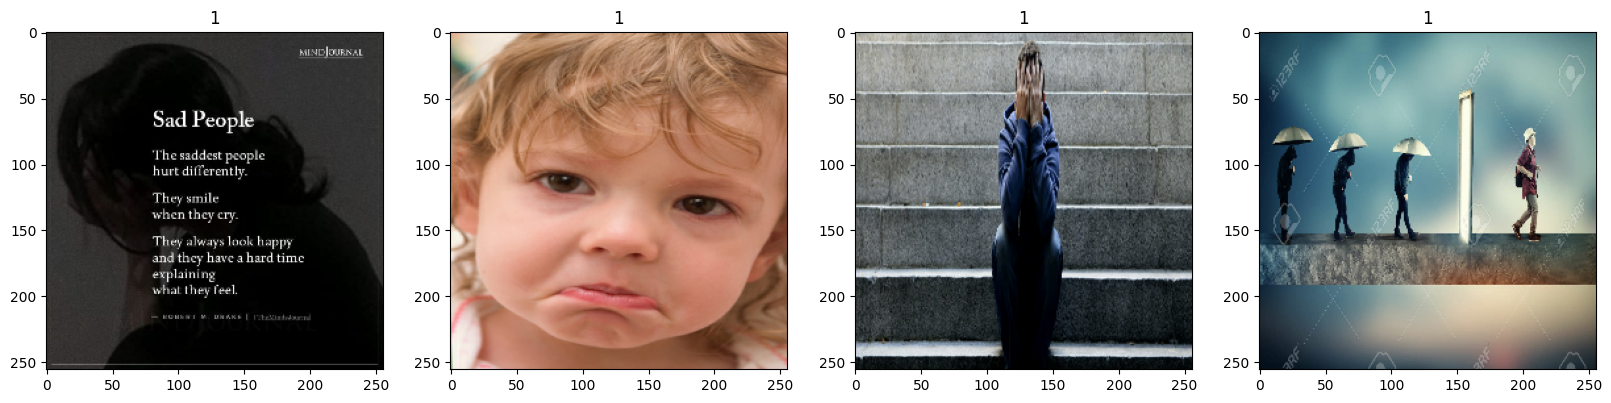

In [99]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

In [100]:
scaled = batch[0] /255

In [101]:
scaled.max()

1.0

### Process Data

In [102]:
data = data.map(lambda x,y: (x/255, y))

In [103]:
scaled_iterator = data.as_numpy_iterator()

In [104]:
batch = scaled_iterator.next()

In [105]:
batch[0].max()

1.0

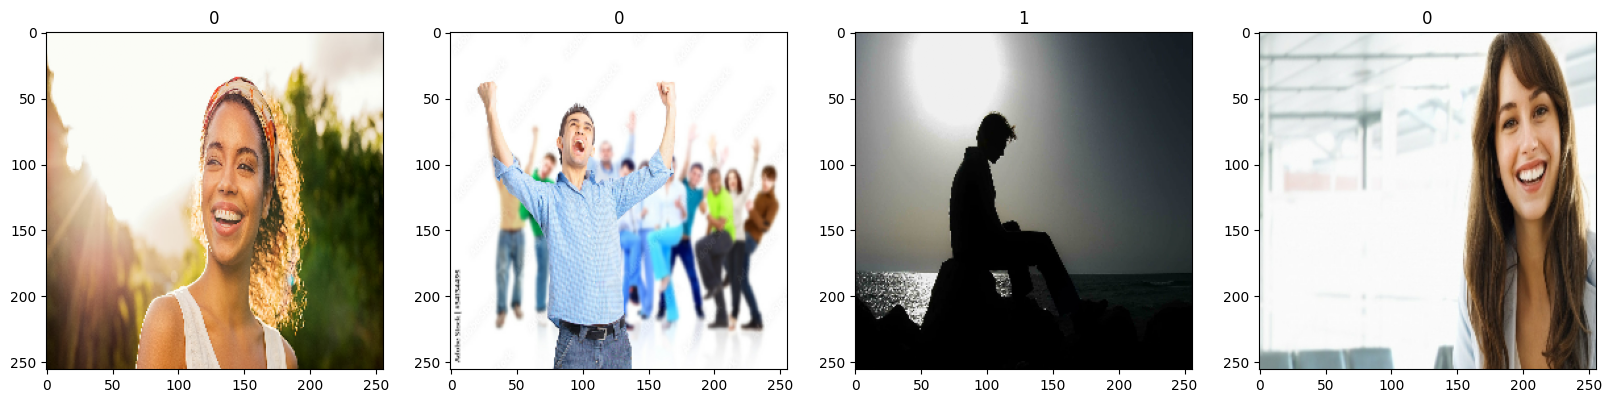

In [106]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img)
    ax[idx].title.set_text(batch[1][idx])

### Split Data

In [116]:
train_size = int(len(data)*.7)
val_size = int(len(data)*.2)+1
test_size = int(len(data)*.1)+1

In [117]:
train_size+val_size+test_size

7

In [118]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

In [124]:
len(test)

0

### Deep Model

In [125]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

In [126]:
model = Sequential()

In [127]:
MaxPooling2D??

In [128]:

model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))
model.add(MaxPooling2D())

model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())

model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())

model.add(Flatten())

model.add(Dense(256,activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [129]:
model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [130]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 127, 127, 16)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 62, 62, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 30, 30, 16)        0

### Train

In [134]:
logdir='logs'

In [135]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [137]:
hist = model.fit(train,epochs=20, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/20
4/4 [==============================] - 14s 2s/step - loss: 1.6044 - accuracy: 0.4609 - val_loss: 0.8587 - val_accuracy: 0.4545
Epoch 2/20
4/4 [==============================] - 10s 2s/step - loss: 0.7428 - accuracy: 0.4922 - val_loss: 0.6414 - val_accuracy: 0.5455
Epoch 3/20
4/4 [==============================] - 10s 2s/step - loss: 0.6599 - accuracy: 0.5547 - val_loss: 0.6060 - val_accuracy: 0.9318
Epoch 4/20
4/4 [==============================] - 10s 2s/step - loss: 0.5924 - accuracy: 0.7031 - val_loss: 0.5590 - val_accuracy: 0.6136
Epoch 5/20
4/4 [==============================] - 12s 2s/step - loss: 0.5719 - accuracy: 0.7031 - val_loss: 0.4878 - val_accuracy: 0.9091
Epoch 6/20
4/4 [==============================] - 9s 2s/step - loss: 0.4520 - accuracy: 0.8047 - val_loss: 0.4544 - val_accuracy: 0.8182
Epoch 7/20
4/4 [==============================] - 9s 2s/step - loss: 0.4231 - accuracy: 0.8438 - val_loss: 0.3396 - val_accuracy: 0.8864
Epoch 8/20
4/4 [====================

### Plot Performance

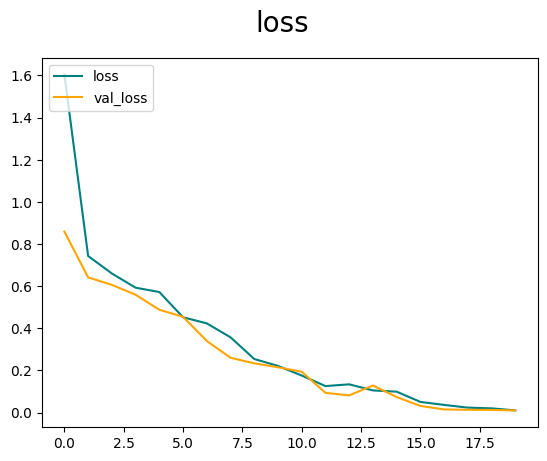

In [139]:
fig = plt.figure()
plt.plot(hist.history['loss'],color='teal',label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

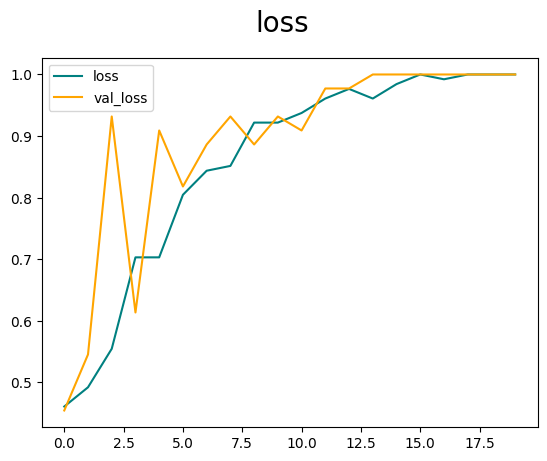

In [140]:
fig = plt.figure()
plt.plot(hist.history['accuracy'],color='teal',label='loss')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_loss')
fig.suptitle('loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

### Evalute Performance

In [141]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [142]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [143]:
len(test)

0

In [148]:
for batch in test.as_numpy_iterator():
    X, y = batch
    yhat = model.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)

In [149]:
print(f'Precision:{pre.result().numpy()}, Recall:{re.result().numpy()}, Accuracy:{acc.result().numpy()}')

Precision:0.0, Recall:0.0, Accuracy:0.0


### Happy Image Test

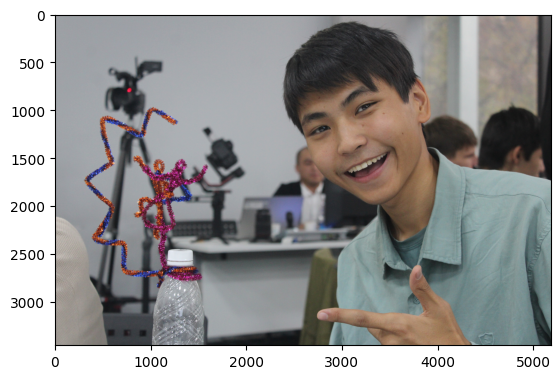

In [192]:
img = cv2.imread('happytest.JPG')
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)
plt.show()

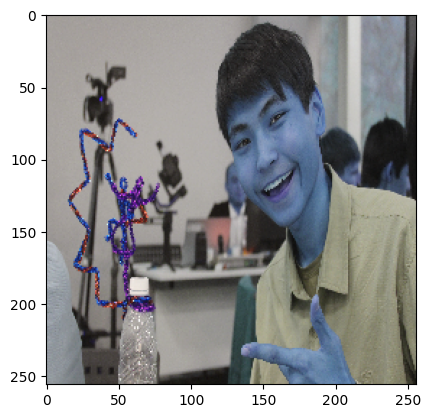

In [193]:
resize = tf.image.resize(img, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [194]:
yhat = model.predict(np.expand_dims(resize/255,0))

1/1 [==============================] - 0s 73ms/step


In [195]:
yhat

array([[0.00688566]], dtype=float32)

In [196]:
if yhat > 0.5:
    print(f'Predicted class is Sad')
else:
    print(f'Predicted class is Happy')

Predicted class is Happy


### Sad Image Test

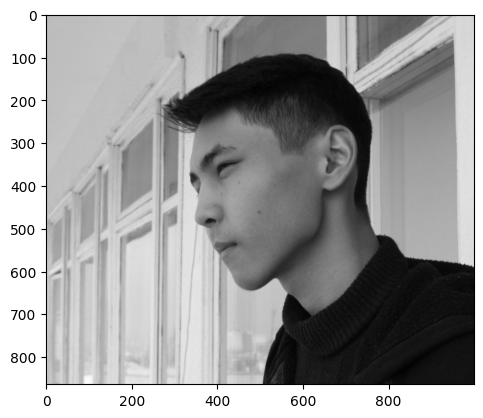

In [197]:
img = cv2.imread('sadtest.jpg')
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)
plt.show()

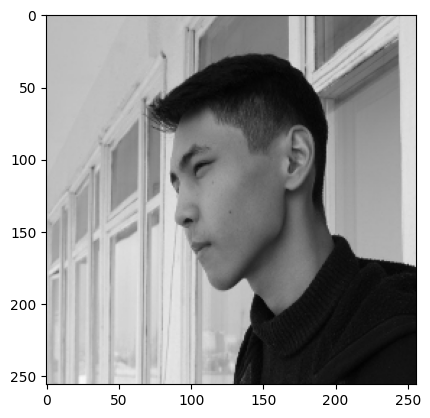

In [198]:
resize = tf.image.resize(img, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [199]:
yhat = model.predict(np.expand_dims(resize/255,0))

1/1 [==============================] - 0s 155ms/step


In [200]:
yhat

array([[0.5004515]], dtype=float32)

In [201]:
if yhat > 0.5:
    print(f'Predicted class is Sad')
else:
    print(f'Predicted class is Happy')


Predicted class is Sad


### Saving

In [202]:
from tensorflow.keras.models import load_model

In [204]:
model.save(os.path.join('models','happysadmodel.h5'))

D:\INAI\Curs\Lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [205]:
new_model = load_model(os.path.join('models','happysadmodel.h5'))

In [207]:
yhatnew = new_model.predict(np.expand_dims(resize/255, 0))

1/1 [==============================] - 0s 101ms/step


In [208]:
if yhatnew > 0.5:
    print(f'Predicted class is Sad')
else:
    print(f'Predicted class is Happy')

Predicted class is Sad
